[실습05] 합성곱 신경망(2)
====================

### 휴먼지능정보공학과 201810800 이혜인

## [GitHub url] : https://github.com/hyeinlee725/Deep_Learning_2020
### 추후에 차근차근 올릴 예정

# 1. Settings

## 1) Important required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
#코랩에서 utils 불러오기
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
import utils

Saving utils.py to utils.py


In [2]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## 2) Hyperparameter

In [3]:
batch_size = 16 # 64 # 1
learning_rate = 0.00001
epoch = 20

n_node = 1024 # customized last layer의 노드 수, 64, 128, 256, 512, 1024
dropratio = 0.5 # 얼마나 드랍시킬지 inverse keepratio

imgsize = 256

# 2. Data Loader

## 트레이닝 데이터

In [4]:
img_dir = '/content/gdrive/My Drive/Colab Notebooks/my_data/train'
train_data = dset.ImageFolder(img_dir, transforms.Compose([
    # ①(512)③②Rcrop <-- Best!!
    transforms.CenterCrop(imgsize*2), # ① CenterCrop(512)
    transforms.RandomCrop(imgsize),   # ② RandomCrop
    transforms.RandomHorizontalFlip(), # ③ RandomHorizontalFlip
    
    #transforms.ToPILImage(),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size,
                             shuffle=True, num_workers=2)

116


## 고정된 데이터 셋

In [5]:
# 2. Dev data
img_dir = '/content/gdrive/My Drive/Colab Notebooks/my_data/val'
dev_data = dset.ImageFolder(img_dir, transforms.Compose({
    #transforms.Scale(256),
    #transforms.RandomSizeCrop(224),
    
    transforms.CenterCrop(size=imgsize),
    #transforms.ToPILImage(),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    }))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                           shuffle=True, num_workers=2)
# 3. Test data
img_dir = '/content/gdrive/My Drive/Colab Notebooks/my_data/test'
test_data = dset.ImageFolder(img_dir, transforms.Compose([
    #transforms.Scale(256),
    #transforms.RandomSizeCrop(224),
    
    transforms.CenterCrop(size=imgsize),
    #transforms.ToPILImage(),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
test_batch = data.DataLoader(test_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

In [6]:
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d" 
      %(train_data.__len__(), dev_data.__len__(),test_data.__len__())),

# for img, labels in train_batch:
#     for j in range(len(imgs)):
#         img = transforms.ToPILImage((imgs[j]))
#         plt.title("labels: %d" % labels[j])
#         plt.imshow(img)
#         plt.show()

# of classes: 2
['cheetah', 'tiger']
{'cheetah': 0, 'tiger': 1}
116
Training: 116, Dev: 18, Test: 60


(None,)

In [7]:
# '.ipynb_checkpoints'가 클래스로 나오는 경우, 새로운 폴더(train, val, test)를 만들어 이동 시킬 것
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['cheetah', 'tiger']
['cheetah', 'tiger']
['cheetah', 'tiger']


# 3. Model

## 1) Pretrained VGG Model

In [8]:
vgg = models.vgg19(pretrained = True)

for name, module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

# cnt = 0
# for i in model.children():
#     print("yhk[%d]" %cnt),
#     print(i)
#     cnt = cnt+1

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth



features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU

In [9]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## 2) Customized Fully Model

In [10]:
base_dim = 64
fsize = 8

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        # [0]: features(conv), [1]: classifier(fc)
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        self.layer1 = nn.Sequential(
        nn.Linear(8*base_dim * fsize * fsize, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio), # 0.3 만큼 drop 하자.
            
        nn.Linear(n_node, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),
            
        nn.Linear(n_node, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),
            
        nn.Linear(n_node, nclass),
        )
        # weight initialization
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data) # ReLU 일때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self, x):
        # layer0의 사이즈를 무식하게 프린트 하여 알아낼 수 있음(batchsize, x,x,x)
        # print(x.size())
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

## 3) Model on GPU

In [11]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [12]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 4. Optimizer & Loss

In [13]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

# 5. Train

In [14]:
import utils

total_time = 0
disp_step = 10

to_train = True

if (to_train == False):
    netname = '/content/gdrive/My Drive/Colab Notebooks/nets/my_data+vgg_10.pkl'
    model = torch.load(netname)
    
else :
    print("3 layer, n_node : %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval() #evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(train_batch, model)
    test_corr = utils.ComputeCorr(train_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
    model.train()
    
    
    netname = '/content/gdrive/My Drive/Colab Notebooks/nets/my_data_vgg19'
    
    #graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
    # 학습을 재시작 한다면
    # netname = '../nets/flowers_vgg19.pkl'
    # model = torch.load(netname)
    
    # 파라미터 학습 여부 설정
    # for params in model.layer0.parameters():
    #    params.required_grad = False
    # for params in model.layer1.parameters():
    #    params.required_grad = True
    # for i in range(34,epoch):

    # 재시작하지 않는다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.."%i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
            
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i%disp_step ==0) or (i == epoch -1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f," %(i, epoch, (loss.cpu()).data.numpy())),
            
            #evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌
            model.eval()
            
            #train, dev, train accr
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(dev_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
            model.train()
            print("time: %.2f sec..." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
        print("Total time: %.2f sec" %total_time)

3 layer, n_node : 1024, dropratio: 0.50
Correct of train: 51.72, dev: 54.31, test: 52.59
0..


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MyVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



[0/20] loss: 0.986,
Correct of train: 61.21, dev: 44.44, test: 44.44
time: 4.67 sec...
Total time: 4.67 sec
1..
Total time: 9.46 sec
2..
Total time: 14.20 sec
3..
Total time: 18.97 sec
4..
Total time: 23.71 sec
5..
Total time: 28.45 sec
6..
Total time: 33.21 sec
7..
Total time: 37.98 sec
8..
Total time: 42.74 sec
9..
Total time: 47.53 sec
10..

[10/20] loss: 0.449,
Correct of train: 82.76, dev: 100.00, test: 100.00
time: 52.38 sec...
Total time: 52.38 sec
11..
Total time: 57.10 sec
12..
Total time: 61.87 sec
13..
Total time: 66.65 sec
14..
Total time: 71.40 sec
15..
Total time: 76.19 sec
16..
Total time: 80.96 sec
17..
Total time: 85.75 sec
18..
Total time: 90.52 sec
19..

[19/20] loss: 0.797,
Correct of train: 91.38, dev: 100.00, test: 100.00
time: 95.31 sec...
Total time: 95.31 sec


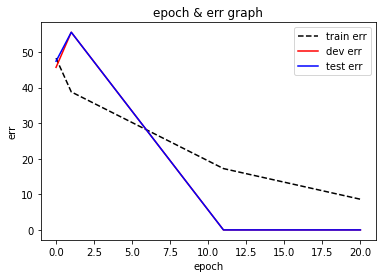

In [15]:
# epoch-err curve
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

# 6. evaluation for dev & test data

Normalized confusion matrix


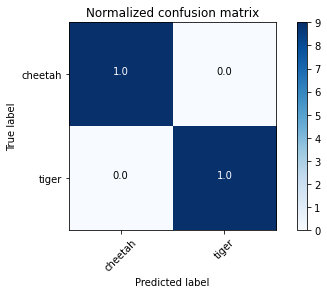

Confusion matrix, without normalization


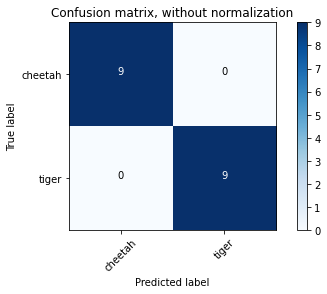

	 acc  |	 pre  |	 rec  |	 f1
 cheetah: 1.00 |	 1.00 |	 1.00 |	 1.00
 tiger: 1.00 |	 1.00 |	 1.00 |	 1.00
*accuracy: 1.00, precision: 1.00, recall: 1.00, *f1 score: 1.00
[AP]
cheetah: 1.00
tiger: 1.00

[mAP] 1.000
[miAP] 1.000


(array([0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]),
 array([0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]),
 array([0.63863689, 0.86500353, 0.75915045, 0.74326062, 0.88650835,
        0.65768653, 0.93742359, 0.90453488, 0.83711642, 0.72209412,
        0.87469447, 0.78808403, 0.94984609, 0.74454486, 0.70391846,
        0.70969212, 0.84891653, 0.7673319 ]))

In [16]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


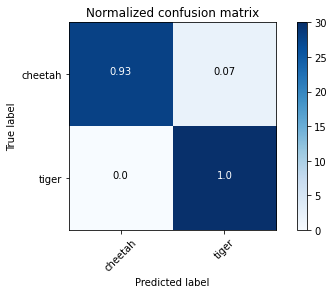

Confusion matrix, without normalization


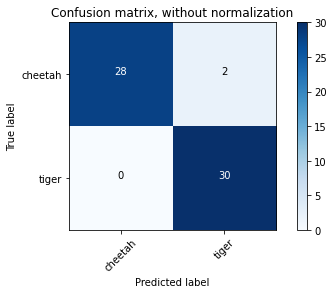

	 acc  |	 pre  |	 rec  |	 f1
 cheetah: 0.97 |	 1.00 |	 0.93 |	 0.97
 tiger: 0.97 |	 0.94 |	 1.00 |	 0.97
*accuracy: 0.97, precision: 0.97, recall: 0.97, *f1 score: 0.97
[AP]
cheetah: 1.00
tiger: 1.00

[mAP] 0.999
[miAP] 0.983


In [17]:
model.eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: cheetah
 True predicted images/total cheetah category: 9 / 9
Predicted probability:
[0.78808403 0.21191597]


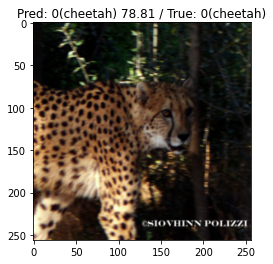

Predicted probability:
[0.87469447 0.12530552]


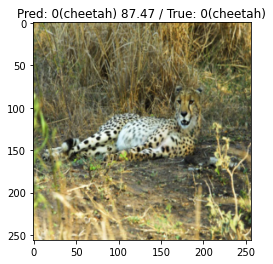

 False predicted images/total cheetah category: 0 / 9
Category: tiger
 True predicted images/total tiger category: 9 / 9
Predicted probability:
[0.06257643 0.9374236 ]


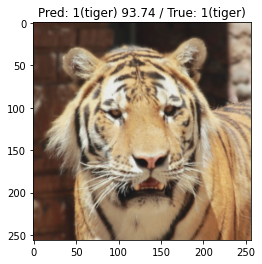

Predicted probability:
[0.15108384 0.8489162 ]


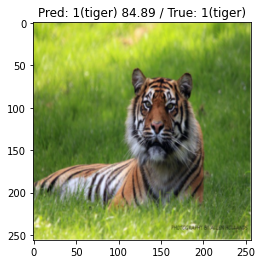

 False predicted images/total tiger category: 0 / 9


In [18]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)